In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
import statsmodels.api as sm
from DLtools.Data_preprocess import load_data, series_to_supervised
from DLtools.evaluation_rec import real_eva_error, error_rec

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Load data

In [3]:
r='data/instant_data/rain_small.csv'
w='data/instant_data/water_small.csv'
rw = load_data(r,w)
df =rw.df.resample('d').mean().astype('float32')
data =df.interpolate(limit=30).fillna(0)
TARGET= 'CPY015_w' # target station

DataFrame shape: (465169, 35)


# Feature selection

In [4]:
def high_corr(data,threshold=.95):
    """Eliminate first columns with high corr"""
    
    corr_matrix = data.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

In [5]:
def corr_w_Y(data,target,threshold= 0.3):
    # correlation 
    corr_test = data.corr(method='pearson')[target]
    corr_test = corr_test[(corr_test> threshold) | (corr_test< -threshold) ]
    corr_test = corr_test.sort_values(ascending=False)
    #corr_test =corr_test[1:] # eliminate Target it own
    return corr_test

In [6]:
col_feature = corr_w_Y(data,TARGET,0.2).index
data = data[col_feature]

In [7]:
high_col = high_corr(data.iloc[:,1:]) #exclude target it own
data.drop(columns=high_col,inplace=True)
data.corr()

,CPY015_w,CPY009_w,PIN004_w
CPY015_w,1.000000,0.494303,-0.266775
CPY009_w,0.494303,1.000000,0.103102
PIN004_w,-0.266775,0.103102,1.000000


# Linear Regression

In [8]:
X = data.drop(columns=[TARGET])
Y = data[TARGET]

trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, shuffle=False)

In [9]:
regr = linear_model.LinearRegression()
regr.fit(trainX,trainY)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 3.1998863
Coefficients: 
 [ 0.11199587 -0.07098383]


In [10]:
# with statsmodels
#X = sm.add_constant(trainX) # adding a constant
 
#model = sm.OLS(trainY, trainX).fit()
#predictions = model.predict(trainX) 
#model.summary()

# Evaluation

In [11]:
trainPredict = regr.predict(trainX)
train_set_mse = (mean_squared_error(trainY, trainPredict))
train_set_r2 = r2_score(trainY, trainPredict)
print(train_set_mse)
print(train_set_r2)

testPredict = regr.predict(testX)
test_set_mse = ((mean_squared_error(testY, testPredict)))
test_set_r2 = r2_score(testY, testPredict)
print(test_set_mse)
print(test_set_r2)

0.042363424
0.3515813355917068
3.5111716
-175.88445234529027


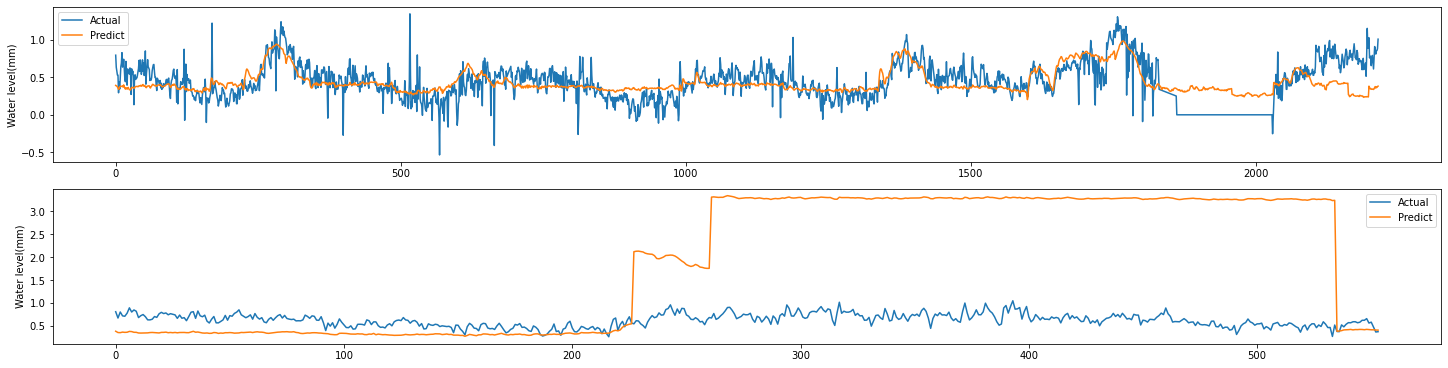

<Figure size 432x288 with 0 Axes>

In [12]:
fig,ax = plt.subplots(2,1,figsize=(20,5),constrained_layout=True)
ax[0].plot(trainY.values,label="Actual")
ax[0].plot(trainPredict,label="Predict")
ax[0].set_ylabel('Water level(mm)')
ax[0].legend()

ax[1].plot(testY.values,label="Actual")
ax[1].plot(testPredict,label="Predict")
ax[1].set_ylabel('Water level(mm)')
ax[1].legend()

plt.show()
plt.savefig('output/Linear_fig.png')

In [13]:
trainPredict = pd.Series(data=trainPredict,index=trainY.index)
testPredict = pd.Series(data=testPredict,index=testY.index)

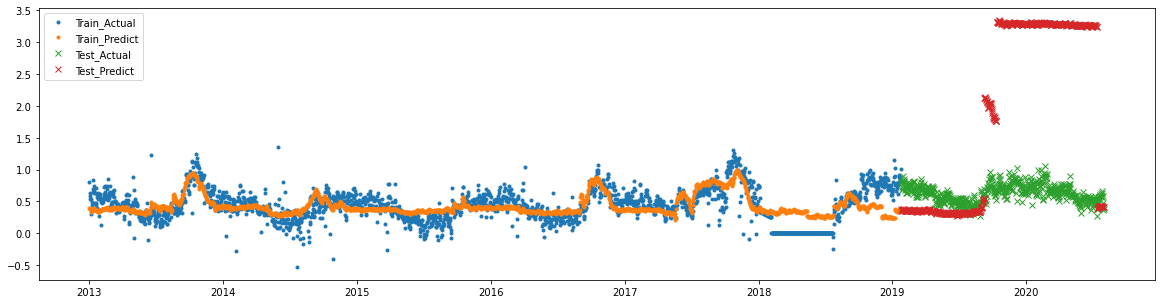

In [14]:
plt.figure(figsize=(20,5))
plt.plot(trainY.sort_index(),'.',label="Train_Actual")
plt.plot(trainPredict.sort_index(),'.',label="Train_Predict")
plt.plot(testY.sort_index(),'x',label="Test_Actual")
plt.plot(testPredict.sort_index(),'x',label="Test_Predict")
plt.legend()
plt.show()

In [15]:
mse_train,nse_train = real_eva_error(trainPredict,trainY.values)
mse_test,nse_test = real_eva_error(testPredict,testY.values)
print("MSE.........|.......NSE")
print(mse_train,"|",nse_train)
print(mse_test,"|",nse_test)

MSE.........|.......NSE
0.042363424 | -0.8442928791046143
3.5111716 | -0.7391582727432251


In [16]:
Rec = pd.DataFrame()
Rec = error_rec(Rec,'Multivari_LinearRegression',list(col_feature),"all","None",mse_train,mse_test,nse_train,nse_test,mse_train,mse_test,nse_train,nse_test)
Rec.to_csv('output/Linear/result.csv')